In [94]:
from fbm import FBM
import numpy as np
from tqdm import notebook as tqdm
import torch

import sigkernel

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 11,
          'figure.figsize': (16, 5),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
pylab.rcParams.update(params)

In [2]:
def soft_thresholding(beta, gamma):
    alpha = np.zeros_like(beta)
    for (i,b) in enumerate(beta):
        if b>gamma:
            alpha[i] = b - gamma
        elif b<-gamma:
            alpha[i] = b + gamma
        else:
            pass
    return alpha

In [23]:
k = 10
L = 300

paths = []
hursts = []

for h in [0.2, 0.5, 0.8]:
    f = FBM(n=L, hurst=h, length=1.)
    for _ in range(k):
        paths.append(0.1*f.fbm())
        hursts.append(h)

paths = sigkernel.transform(np.array(paths), at=True)
# paths = torch.tensor(paths, dtype=torch.float64, device='cpu')
paths = torch.tensor(paths, dtype=torch.float32, device='cuda')

In [37]:
# Specify the static kernel 
# static_kernel = sigkernel.LinearKernel()
static_kernel = sigkernel.RBFKernel(sigma=0.1)

# Initialize the corresponding signature kernel
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=0)

# Gram matrix train
G_train = signature_kernel.compute_Gram(paths, paths, sym=True).cpu().numpy()

In [38]:
beta0 = 0.1*np.random.randn(k)

In [39]:
def loss(beta):
    n = len(beta)
    l = 0.
    for i in range(n):
        for j in range(n):
            l += (1./n - beta[i])*(1./n - beta[j])*G_train[i,j]
    return l

In [40]:
def proximal_gradient(beta0, gamma, max_iter=100):
    losses = []
    for k in tqdm.tqdm(range(max_iter)):
        beta_temp = torch.tensor(beta0)
        beta_temp.requires_grad = True
        l = loss(beta_temp)
        l.backward()
        grad_beta = beta_temp.grad.numpy()
        beta = soft_thresholding(beta0-gamma*grad_beta, gamma)
        beta0 = beta
        losses.append(l)
    return losses, beta 

In [41]:
losses, beta_optimal = proximal_gradient(beta0, gamma=0.0001, max_iter=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [52]:
selected_indices = np.nonzero(np.abs(beta_optimal) > 0.07)[0]

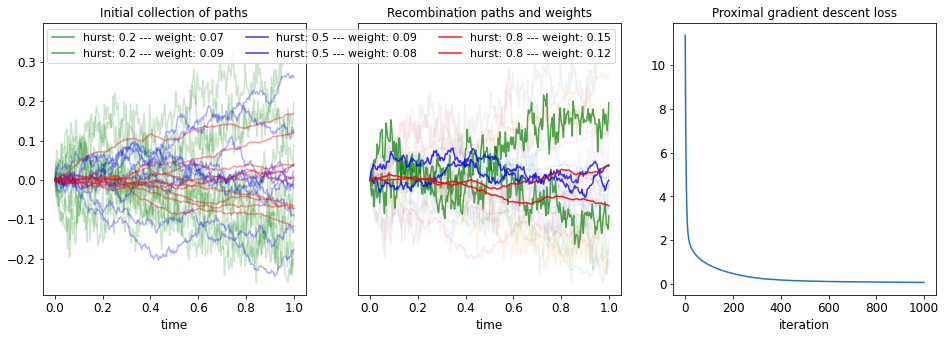

In [95]:
fig, ax = plt.subplots(1,3)

for k,p in enumerate(paths.cpu().numpy()):
    if hursts[k]==0.2:
        c = 'g'
        alpha = 0.2
    elif hursts[k]==0.5:
        c = 'b'
        alpha = 0.3
    else:
        c ='r'
        alpha = 0.4
    ax[0].plot(np.linspace(0,1,L+1), p[:,1], alpha=alpha, c=c)
    
ax[0].set_title('Initial collection of paths')
ax[0].set_xlabel('time')
ax[2].plot(losses)
ax[2].set_title('Proximal gradient descent loss')
ax[2].set_xlabel('iteration')
ax[1].set_yticks([])

for k, p in enumerate(paths.cpu().numpy()):
    if k in selected_indices:
        if hursts[k]==0.2:
            c = 'g'
            alpha = 0.7
        elif hursts[k]==0.5:
            c = 'b'
            alpha = 0.8
        else:
            c ='r'
            alpha = 0.9
        ax[1].plot(np.linspace(0,1,L+1), p[:,1], alpha=alpha, c=c, 
                   label=f'hurst: {hursts[k]} --- weight: {np.round(beta_optimal[k],2)}')
    else:
        ax[1].plot(np.linspace(0,1,L+1), p[:,1], alpha=0.1)
        
ax[1].set_title('Recombination paths and weights')
ax[1].legend(ncol=3)
ax[1].set_xlabel('time')
plt.savefig('./pictures/recombination.png')
plt.show()